In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# The characteristics of NEETs

So far, we've taken a look at general NEET rates in the U.S. by various demographic characteristics, and over time. We see that women tend to have slightly higher NEET rates, though this varies by age and demographic qualities. For example, NEET rates are higher for men among those without a disability or any kids. We've also seen that NEET rates for men have been fairly stable over time, while rates for women have noticeably decreased, largely mirroring men now. 

While we have a good sense of what the NEET rates are now, we still haven't fully figured out *why* some men and women are NEETs and why others aren't. We've briefly looked at some explanations, like childrearing and disability status, both clearly playing a role. But outside of these conditions, why is some man or women in their early 20s not in school or employed?

I don't expect to fully solve this question here, as there are certainly qualitative aspects to this question that we can't really study here, but we can at least take a look. In order to do this, we'll be relying on the CPS ASEC data, as there are a lot of interesting questions asked in this annual survey. Here are some example variables:
- `WHYNWLY`: reason for not working last year (e.g., 'Could not find work' or 'Ill or disabled')
- `INCWELFR`: welfare (public assistance) income recieved during previous year
- `OFFPOV`: official poverty status

There's a lot we can look at, and while we won't cover everything here, I hope we'll find some interesting things.

## Load the data

We'll again be using our `get_CPS()` function to pull ASEC data. For now, we don't really need every year, so let's just pull data for 2024.

In [2]:
import os
from ipumspy import readers
import sys

sys.path.append('..')

from scripts.clean_ipums import get_CPS

In [2]:
my_vars = ['AGE', 'SEX', 'RACE', 'HISPAN', 'NCHILD', 'EDUC',
           'DIFFANY', 'EMPSTAT', 'LABFORCE', 'SCHLCOLL', 'STATEFIP',
           'WORKLY', 'WANTJOB', 'WNLWNILF', 'WHYNWLY', 'ACTNLFLY',
           'INCWELFR', 'OFFPOV', 'HEALTH', 'DISABWRK']

get_CPS(years=2024, 
        vars=my_vars, 
        filename='characteristics_2024', 
        filepath='../datasets' 
        ) # extracting a fwf & xml, named '../datasets/characteristics_[year].[dat.gz/xml]'

Let's load in only ASEC samples to speed this up a bit.

In [35]:
%%capture

ddi_asec24 = readers.read_ipums_ddi('../datasets/characteristics_2024.xml')
iter_asec24 = readers.read_microdata_chunked(ddi_asec24, filename='../datasets/characteristics_2024.dat.gz', chunksize=10000)
asec24 = pd.concat([df[df['ASECFLAG'] == 1] for df in iter_asec24], ignore_index=True)

Let's take a quick look at our 2024 data.

In [4]:
asec24.shape

(144265, 32)

In [9]:
(asec24['SEX'] == 1).mean()

np.float64(0.48827504938827854)

In [10]:
asec24['MONTH'].value_counts()

MONTH
3    144265
Name: count, dtype: Int64

Let's drop out respondents with unknown school or employment status.

In [5]:
asec24 = asec24.query('EMPSTAT > 0 and SCHLCOLL > 0')
asec24.shape

(71274, 32)

We should just be limited to 16-54 year-olds, as `SCHLCOLL` in the ASEC [is recorded](https://cps.ipums.org/cps-action/variables/SCHLCOLL#description_section) for that age range.

In [12]:
asec24['AGE'].describe()

count      71274.0
mean     35.152019
std      11.158452
min           16.0
25%           26.0
50%           36.0
75%           44.0
max           54.0
Name: AGE, dtype: Float64

We have a lot of variables to map, so let's do that next. First, our basic demographic variables that we've been using up to now.

In [6]:
import us

# NEET
asec24['NEET'] = 'not_neet'
asec24.loc[(asec24['EMPSTAT'].isin(range(20,37))) & (asec24['SCHLCOLL'] == 5), 'NEET'] = 'neet' # NEET conditions

#Gender
gender_codes = {1 : 'men', 2 : 'women'} # map gender codes
asec24['sex'] = asec24['SEX'].map(gender_codes)

# Race
race_codes = [
    ((asec24['RACE'] == 100) & (asec24['HISPAN'] == 0)),
    ((asec24['RACE'] == 200) & (asec24['HISPAN'] == 0)),
    ((asec24['RACE'].isin(range(650, 653))) & (asec24['HISPAN'] == 0)),
    ((asec24['HISPAN'] > 0) & (asec24['HISPAN'] < 902))
]
race_choices = ['white', 'black', 'asian', 'hispanic']
asec24['race_cat'] = np.select(race_codes, race_choices, default = 'other')

# State
state_names = us.states.mapping('fips', 'name') # dictionary with STATEFIP as key
state_names['11'] = 'District of Columbia' # DC isn't included, so manually add it
asec24['state'] = asec24['STATEFIP'].astype(str).str.zfill(2) 
asec24['state'] = asec24['state'].map(state_names)

# Kids
child_dict = {i : 'has_child' for i in range(10) if i > 0}
child_dict[0] = 'no_child'
asec24['kids'] = asec24['NCHILD'].map(child_dict)


# Disability
disability_dict = {1 : 'no_dis', 2 : 'has_dis'}
asec24['dis'] = asec24['DIFFANY'].map(disability_dict)

Next, we'll map the new variables we've introduced. Let's also briefly identify them now:
- `WORKLY`: whether an individual was working in the past year

- `WANTJOB`: whether an individual, conditional on them not being in the labor force, wants a job

- `WNLWNILF`: time passed since an individual not in the labor force has last worked

- `WHYNWLY`: main reason for not working in the previous year

- `ACTNLFLY`: main activity when not in the labor force in the past year

- `INCWELFR`: pre-tax income recieved from public assistance incomes from last year

- `OFFPOV`: poverty status

- `HEALTH`: health status

- `DISABWRK`: work disability status

In [7]:
workly = {0 : 'NIU', 1 : 'no', 2 : 'yes'}
asec24['workly'] = asec24['WORKLY'].map(workly)

wantjob = {0 : 'NIU', 1 : 'no', 2 : 'yes', 3 : 'maybe', 4 : 'unsure', 9 : 'unknown'}
asec24['wantjob'] = asec24['WANTJOB'].map(wantjob)

asec24['whenlastworked'] = 'temp'
whenlastworked = {0 : 'NIU', 10 : 'past_twelve_months', 30 : 'never_worked'}
asec24['whenlastworked'] = asec24['WNLWNILF'].map(whenlastworked)
asec24.loc[asec24['WNLWNILF'].isin(range(20,26)), 'whenlastworked'] = 'more_than_one_year'

whynwly = {0 : 'NIU', 1 : 'could_not_find_work', 2 : 'ill_or_disabled', 3 : 'care_home_or_family',
           4 : 'going_to_school', 5 : 'retired', 6 : 'armed_forces', 7 : 'other', 9 : 'missing'}
asec24['whynotwork'] = asec24['WHYNWLY'].map(whynwly)

activity = {0 : 'NIU', 10 : 'ill_or_disabled', 20 : 'care_home_or_family', 30 : 'going_to_school', 40 : 'retired',
            50 : 'other', 51 : 'looking_for_work', 52 : 'no_work_available', 53 : 'unpaid_work', 54 : 'armed_forces'}
asec24['activity'] = asec24['ACTNLFLY'].map(activity)

asec24.loc[asec24['INCWELFR'] == 999999, 'INCWELFR'] = np.nan

pov = {1 : 'below', 2 : 'above', 3 : 'NIU'}
asec24['poverty'] = asec24['OFFPOV'].map(pov)

disabwrk = {0 : 'NIU', 1 : 'no', 2 : 'yes'}
asec24['workdis'] = asec24['DISABWRK'].map(disabwrk)

Now we can look at our data. 

## Work Characteristics

Let's look at the working habits of NEETs: why they're not working, when they last worked, and more. Let's first look at the share of NEETs that weren't working in their survey year (March 2024) and in the past year of 2023.

In [8]:
neets24 = asec24.query('AGE >= 16 and AGE <= 24 and NEET == "neet"').copy()
neets24.shape

(1856, 45)

Only 1856 observations is quite small for our 2024 NEETs. For now, let's broaden our age-range to 16-29, which we're allowed to do with the ASEC.

In [9]:
neets24 = asec24.query('AGE >= 16 and AGE <= 29 and NEET == "neet"').copy()
neets24.shape

(3213, 45)

That's a bit better. Okay, let's look at how many NEETs didn't work in the past year.

In [32]:
notworkpastyear = neets24.groupby(['sex', 'workly'])['ASECWT'].sum().unstack()
notworkpastyear = notworkpastyear.eval('no / (no + yes) * 100')
notworkpastyear

sex
men      66.794811
women    73.404265
dtype: float64

About two-in-three male and female NEETs didn't work at all in 2023. The natural next question, then, is why didn't they work?

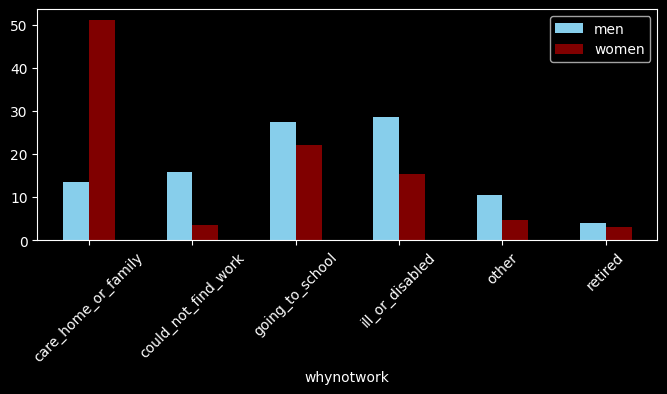

In [88]:
whynotwork = neets24.groupby(['sex', 'whynotwork'])['ASECWT'].sum().unstack()
whynotwork = whynotwork.drop('NIU', axis=1)

whynotwork_pct = pd.DataFrame(columns=whynotwork.columns, index=['men', 'women'])

for i in whynotwork.columns:
    whynotwork_pct.loc['men', i] =  whynotwork.loc['men', i] / np.sum(whynotwork.loc['men']) * 100
    whynotwork_pct.loc['women', i] =  whynotwork.loc['women', i] / np.sum(whynotwork.loc['women']) * 100

whynotwork_pct.T.plot(kind='bar', figsize=(8,3), color={'men' : 'skyblue', 'women' : 'maroon'})
plt.xticks(rotation=45);


Of the NEETs who didn't work in the previous year either, men were most likely to be sick or going to school, and women were most likely to be taking care of the home or their family. The responses of going to school are a bit weird, given that they were recorded as not being in school in March 2024; maybe they graduated from school in the Winter of 2023, but have been unemployed since? 

Anyway, let's look at the last time that our NEETs worked. 

In [97]:
lastwrk = neets24.groupby(['sex', 'whenlastworked'])['ASECWT'].sum().unstack()
lastwrk = lastwrk.drop('NIU', axis=1)
print(lastwrk)

whenlastworked  more_than_one_year  never_worked  past_twelve_months
sex                                                                 
men                       49807.02       77846.9             4781.47
women                     28170.55       46726.0             9211.28


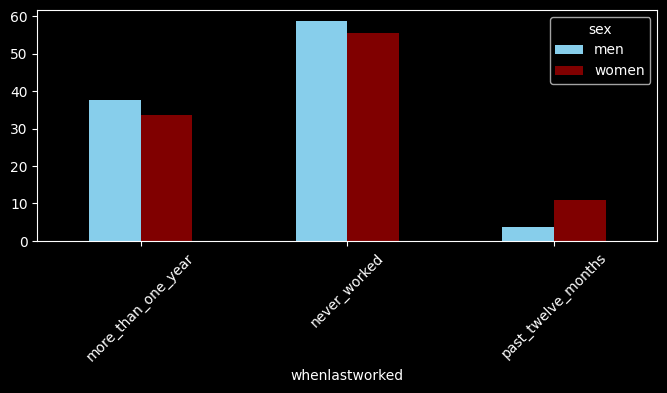

In [99]:
lastwrktotmen = lastwrk.loc['men'].sum()
lastwrktotwomen = lastwrk.loc['women'].sum()

for i in lastwrk.columns:
    lastwrk.loc['men', i] = lastwrk.loc['men', i] / lastwrktotmen * 100 
    lastwrk.loc['women', i] = lastwrk.loc['women', i] / lastwrktotwomen * 100

lastwrk.T.plot(kind='bar', figsize=(8,3), color={'men' : 'skyblue', 'women' : 'maroon'})
plt.xticks(rotation=45);

Wow, about six-in-ten NEETs who didn't work in 2023-March 2024 have never worked, while about three to four-in-ten last worked more than a year ago. It seems like we have a portion of NEETs that have never worked for pay. Remember that the about two-thirds of March 2024 NEETs didn't work in 2023 either, so this would mean that about 40% of NEETs have never worked for pay before. 

Next, let's look at the share of NEETs that want a job.

In [105]:
want_job = neets24.groupby(['sex', 'wantjob'])['ASECWT'].sum().unstack()
want_job = want_job.drop('NIU', axis=1)
want_job = want_job.eval('want_job_rate = yes / (yes + no) * 100')
want_job['want_job_rate']

sex
men      19.286763
women    12.933689
Name: want_job_rate, dtype: float64

Only about 20% of male NEETs and 13% of female NEETs not in the labor force actually want a job. Of course, we're now wondering why they don't want a job and, relatedly, how they're supporting themselves.

## Disability, Health, and Welfare

Naturally, we ask what is preventing NEETs from attending school or entering the workforce. We already have some reasonse from before, namely taking care of children/family or being disabled. But let's further explore this now. 

Let's look at the share of NEETs recieving any welfare from public assistance programs.

In [15]:
neets24['receive_welfare'] = 'no'
neets24.loc[(neets24['INCWELFR'] > 0) & (neets24['INCWELFR'].notnull()), 'receive_welfare'] = 'yes'

recieving_welfare = neets24.groupby(['sex', 'receive_welfare'])['ASECWT'].sum().unstack()
recieving_welfare = recieving_welfare.eval('welfare_rate = yes / (yes + no) * 100')
print(recieving_welfare['welfare_rate'])

sex
men      0.407091
women    3.630877
Name: welfare_rate, dtype: float64


Very few NEETs are recorded as receiving welfare, with women being more likely than men to be receiving some welfare, presumably from child-focused public assistance. 

Let's look at disability. What share of NEETs have a work disability?

In [18]:
work_dis = neets24.groupby(['sex', 'workdis'])['ASECWT'].sum().unstack()
work_dis = work_dis.eval('workdis_rate = yes / (yes + no) * 100')
print(work_dis['workdis_rate']) 

sex
men      17.124762
women    11.648293
Name: workdis_rate, dtype: float64


About one-in-ten NEET women and one-in-five NEET men have a work disability, which I imagine is much higher than the general population. Let's also look at the general health of NEETs. The variable `HEALTH`, is an ordinal variable describing the respondent's health condition on a five-point scale, with 1 being 'excellent' and 5 being 'poor.' While we generally shouldn't be averaging an ordinal variable, let's do it here and see the results.

In [31]:
health = neets24.groupby('sex')[['HEALTH', 'ASECWT']].apply(lambda x: np.average(x['HEALTH'], 
                                                                                 weights=x['ASECWT']))
health


sex
men      2.344925
women    2.265029
dtype: float64

A 2 is equivalent to 'very good' and a 3 is 'good,' so it doesn't really seem like NEETs rate their health as poor. 

As a final question here, let's look at how many NEETs are qualified as below the poverty limit.

In [33]:
poverty = neets24.groupby(['sex', 'poverty'])['ASECWT'].sum().unstack()
poverty = poverty.eval('pov_rate = below / (above + below) * 100')
print(poverty['pov_rate'])

sex
men      24.733399
women    30.709358
Name: pov_rate, dtype: float64


Wow, about one-in-four NEET men and one-in-three NEET women are classified as being in poverty. So, we have a population of men and women who are more likely to be impoverished, to have not worked at all for more than one year (or ever at all), and to have a work disability. We still haven't really solved *how* NEETs are supporting themselves financially, with the question for men being more open; we can imagine that since a large share of NEET women are taking care of children or family, they have support through their spouse, or government assistance. Of course, dealing with such a small sample doesn't really help either. 

Either way, we have learned a few interesting things as noted above. I think the most interesting is that about two-in-three NEET men and women hadn't been employed for an entire year. That statistic, coupled with the share of them being disabled or never having worked, points to NEET status likely being a chronic condition. As we saw in our time-series analyses in chapter 2, while there are temporal shocks to the NEET population from recessions and such, there's a fairly stable share of young men and women who have been NEETs all the way back to the 90s. 

Additionally, it could be argued from our analyses that NEET men are more concerning than NEET women: a sizeable share of NEET woman are taking care of children or their family; we wouldn't view her situation in the same way as a young man who hasn't worked for a whole year due to illness or simply not finding work. 

## Conclusion

We've looked at the characteristics of NEETs and found some interesting qualities of this population, while having some questions left unanswered. As we've seen in chapter 2, unfortunately there's about 10% of young men and women with no disability or kids who have consistently been unemployed and not even in the labor force. While there may be policies to help these people get back into the economy, I don't think it'll be easy, and I'm definitely not sure how we would go about it. 